In [2]:
from collections import Counter
import os

from graphviz import Source
from IPython.display import display, Markdown
import matplotlib.pyplot as plt
from matplotlib.ticker import EngFormatter
import networkx as nx
import numpy as np
from scipy import stats
import pandas as pd
import seaborn as sns


sns.set_style('white')
sns.set_context('notebook')

def plot_style(figsize=(12, 6), labelsize=20, titlesize=24, ticklabelsize=14, **kwargs):
   basic_style = {
       'figure.figsize': figsize,
       'axes.labelsize': labelsize,
       'axes.titlesize': titlesize,
       'xtick.labelsize': ticklabelsize,
       'ytick.labelsize': ticklabelsize,
       'axes.spines.top': False,
       'axes.spines.right': False,
       'axes.spines.left': False,
       'axes.grid': False,
       'axes.grid.axis': 'y',
   }
   basic_style.update(kwargs)
   return plt.rc_context(rc=basic_style)

blue = sns.xkcd_rgb['ocean blue']

In [2]:
def new_count_row(all_clone_names, clone_name=None):
    """ Create a DataFrame row with one entry per clone name. 
    
    If `clone_name` is not None, initialize that entry to 1.
    """
    row = pd.Series(data=0, index=all_clone_names)
    if clone_name is not None:
        row[clone_name] = 1
    return row

def dfs_clones_count(g, clones, all_clone_names, source_node):
    clones_count = pd.DataFrame({sample_name: new_count_row(all_clones, clone_name) for sample_name, clone_name in clones.items()})
    for pre_node, post_node, edge_label in nx.dfs_labeled_edges(g, source_node):
        if edge_label is not 'reverse' or pre_node == post_node: 
            continue
        pre_node_counter = clones_count.get(pre_node, new_count_row(all_clones))
        if post_node not in clones_count.columns:
            print('!! possible mutation in a leaf: not found', post_node)
            continue
        clones_count[pre_node] = pre_node_counter + clones_count[post_node]

    return clones_count

def purity(clones_count):
    return clones_count.div(clones_count.sum(axis=0), axis=1)

def get_root_node(t):
    root_nodes = [n for n,d in t.in_degree() if d==0]
    assert len(root_nodes) == 1
    root_node = root_nodes[0]
    return root_node

<>:14: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:14: SyntaxWarning: "is not" with a literal. Did you mean "!="?
/tmp/ipykernel_2633564/661853690.py:14: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if edge_label is not 'reverse' or pre_node == post_node:


In [3]:
time_to_width_map = {14.0: 1, 180.0: 5}

def rgb_to_hex(colortuple):
    return '#' + ''.join(f'{int(i):02X}' for i in colortuple)

    
def mem_timepoint_style_tree(tree, cell_id_to_time_clone, cell_id_to_mem_score_clone, mem_score_colors):
    for n in tree.nodes:
        node_dict = tree.nodes[n]
        if n.startswith('s'):
            # This is the style for sample nodes
            node_dict['shape'] = 'circle'
            time = cell_id_to_time_clone[n]
            node_dict['penwidth'] = time_to_width_map.get(time, 0)
            if n not in cell_id_to_mem_score_clone:
                node_dict['fillcolor'] = 'black'
                node_dict['fontcolor'] = 'white'
            else:
                score = cell_id_to_mem_score_clone[n]
                if np.isnan(score):
                    node_dict['fillcolor'] = 'white'
                    node_dict['color'] = 'black'
                else:
                    node_dict['fillcolor'] = rgb_to_hex(mem_score_colors[int(score*100)])
    tree.graph['node']['shape'] = 'square'
    tree.graph['node']['fontcolor'] = 'black'
    tree.graph['node']['color'] = 'black'
    tree.graph['node']['style'] = 'filled,solid'
    tree.graph['edges'] = {'arrowsize': '4.0'}

# Load clones data

In [4]:
meta_data = pd.read_csv('/home/carler/lab/t_cell/meta_data/2023_04_06_A1_06_A1_30_YFV2003_JH_meta_data_invivo_t_cell_mito_project.csv', index_col=0)

# Load tree

In [5]:
datasets = ['A1_06', 'A1_30']

In [6]:
import copy 
donor_dict = {'A1_06': [],
              'A1_30': []}

In [7]:
error_rate = 0.0556
tree_number = 0
INPUT_PATH = '/home/carler/lab/t_cell/phylogeny/data/output/P20407/2023_4_25_mt-scite_2_pos_filter/'
OUTPUT_PATH = '/home/carler/lab/t_cell/phylogeny/tree_figures/'

In [8]:
all_trees = copy.deepcopy(donor_dict)
mem_eff_score = copy.deepcopy(donor_dict)
all_tree_ids = copy.deepcopy(donor_dict)

cell_id_to_mem_score = copy.deepcopy(donor_dict)
cell_id_to_time = copy.deepcopy(donor_dict)


for donor in datasets: 
    all_trees[donor] = {}
    mem_eff_score[donor] = pd.read_csv(f'/home/carler/lab/t_cell/data/memeff_score/{donor}_mem_eff.csv', index_col=0)

    
    all_tree_ids[donor] = {}
    cell_id_to_mem_score[donor] = {}
    cell_id_to_time[donor] = {}

    for clone in os.listdir(f'{INPUT_PATH}{donor}'): 
        all_trees[donor][clone] = nx.drawing.nx_pydot.read_dot(f'{INPUT_PATH}{donor}/{clone}/{clone}_map{tree_number}.gv')
        #all_trees[donor][clone].graph['node']['shape'] = 'square'
        #all_trees[donor][clone].graph['node']['fontcolor'] = 'white'
        #all_trees[donor][clone].graph['edges'] = {'arrowsize': '4.0'}
        all_trees[donor][clone].remove_node('\\n')

        clone_id = clone.split('_')[1]
        tree_ids = pd.read_csv(f'{INPUT_PATH}{donor}/{clone}/{error_rate}_meta_data_{clone_id}.csv', index_col=0)
        tree_ids_dict = dict(zip(tree_ids.columns, ['s'+ str(x) for x in range(0, len(tree_ids.columns))]))
        all_tree_ids[donor][clone] = tree_ids_dict


        cell_id_to_mem_score[donor][clone] = dict(zip(tree_ids.columns, mem_eff_score[donor].loc[tree_ids.columns, 'Celltype'].values))
        cell_id_to_time[donor][clone] = dict(zip(tree_ids.columns, meta_data.loc[tree_ids.columns, 'Timepoint'].values))

        cell_id_to_mem_score_s = {}
        cell_id_to_time_s = {}
        for key, value in tree_ids_dict.items():
            cell_id_to_mem_score_s[value] = cell_id_to_mem_score[donor][clone][key]
            cell_id_to_time_s[value] = cell_id_to_time[donor][clone][key]

        cell_id_to_mem_score[donor][clone] = cell_id_to_mem_score_s
        cell_id_to_time[donor][clone] = cell_id_to_time_s

In [15]:
for i, j in all_tree_ids['A1_06']['0.0556_A28'].items(): 
    if j == 's35': 
        print(i)
        print(j)


A1_06_D14_p6_K17
s35


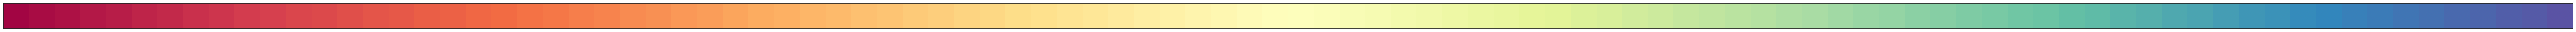

In [19]:
mem_score_colors = sns.color_palette("Spectral_r", 100)[::-1]
sns.palplot(mem_score_colors)
mem_score_colors = np.array(mem_score_colors) * 255

In [20]:
from networkx.drawing.nx_agraph import graphviz_layout, to_agraph
for donor in datasets: 
    for clone, tree in all_trees[donor].items(): 
        mem_timepoint_style_tree(tree=tree, cell_id_to_time_clone=cell_id_to_time[donor][clone], cell_id_to_mem_score_clone=cell_id_to_mem_score[donor][clone], mem_score_colors=mem_score_colors)
        g = to_agraph(tree)
        g.layout(prog='dot')
        g.draw(f'{OUTPUT_PATH}{donor}/{clone}_timepoint_mem_eff.pdf')

In [4]:
from networkx.drawing.nx_agraph import graphviz_layout, to_agraph

In [18]:
tree = nx.drawing.nx_pydot.read_dot(f'/home/carler/lab/t_cell/phylogeny/data/output/P20407/2023_4_27_mt_scite_entire_dataset/A1_30/0.0556_A1_30_map0.gv')
tree.remove_node('\\n')
g = to_agraph(tree)
g.layout(prog='dot')

In [19]:
g

In [20]:
g.draw(f'../entire_tree_A1_30_1mil.pdf')

In [16]:
g

<AGraph b'G' <Swig Object of type 'Agraph_t *' at 0x7f6f43183210>>